## Code to compute MLE for two parameters for coupled PHUs (with mobility matrix) using synthetic data

length of t is 20
length of tmoh is 200
/Users/sudhipv/documents/coupledode/codes/phudata
/Users/sudhipv/documents/coupledode/codes/phudata
shape of M is (4, 2, 2, 200)
/Users/sudhipv/documents/coupledode/codes/mobility_tensor/stochastic_Tor_Durham
(52, 2, 2)
m range is 3
length of tsw is 61
length of tsw is 61
length of tsw is 51


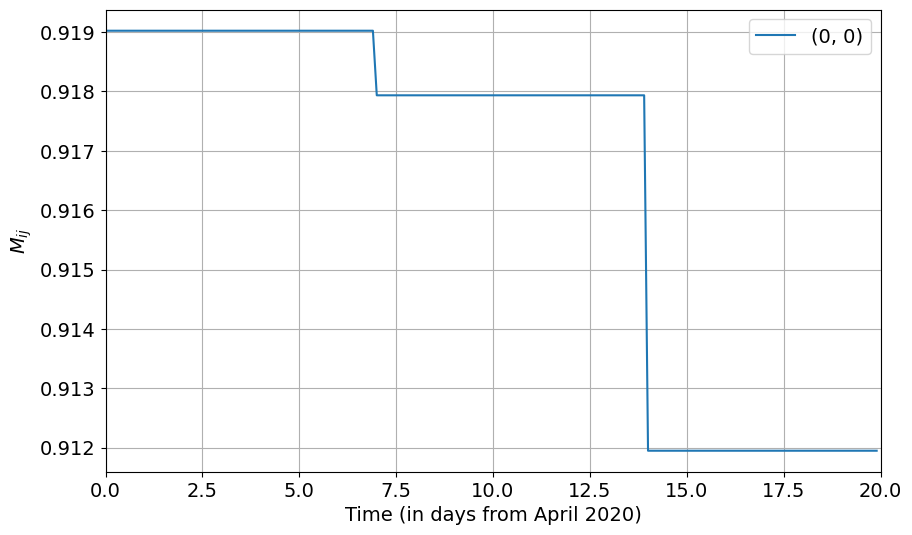

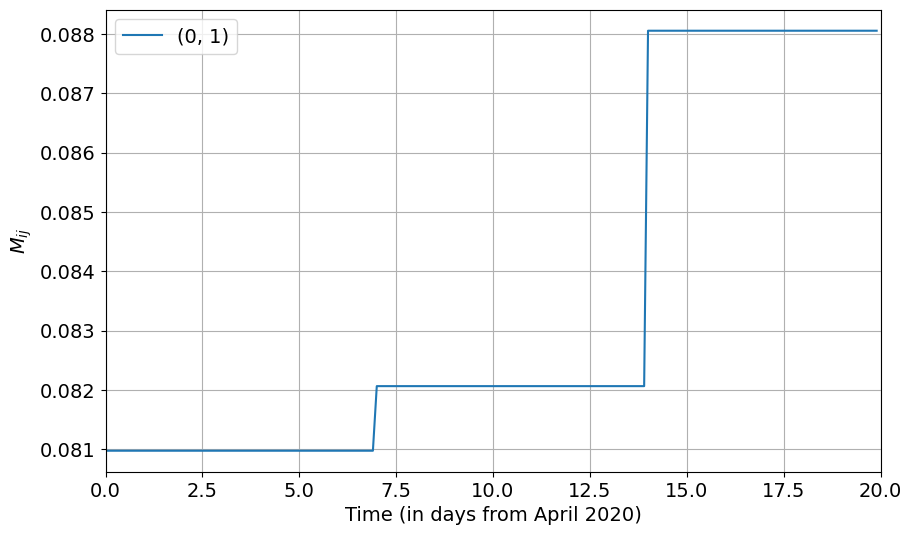

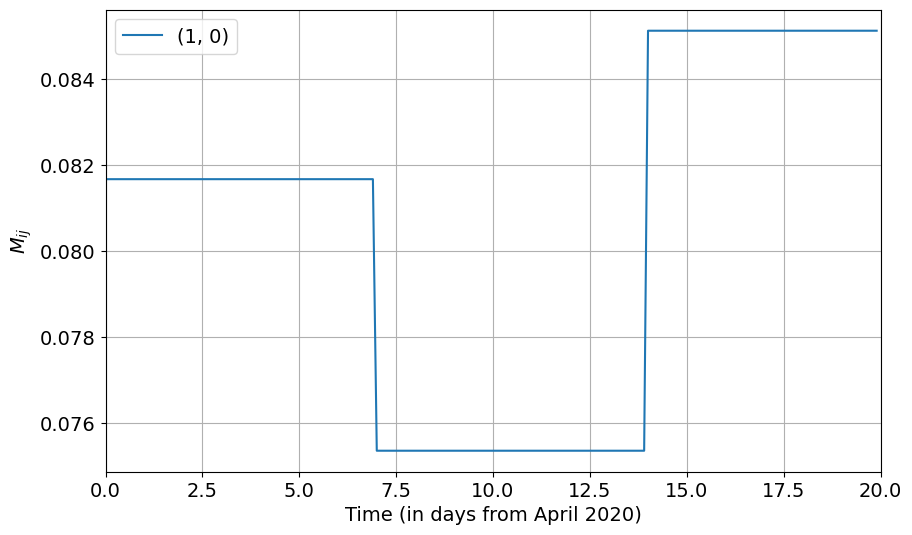

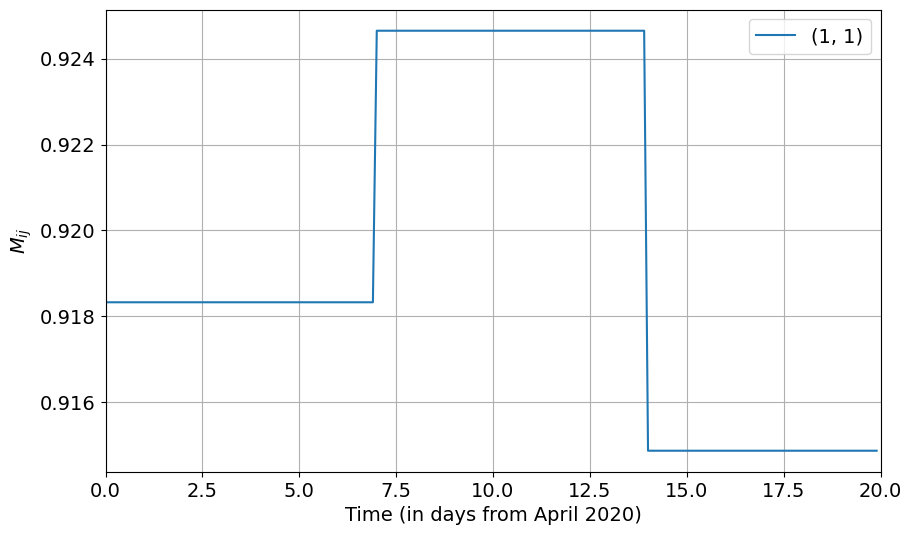

initial infected in PHU1 430.0
total population in PHU1 2794356.0
initial infected in PHU2  94.0
total population in PHU2  696992.0


In [2]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

dt = 0.1
tlim = 20
tstart = 0
t = np.arange(tstart, tlim, 1)
tmoh = np.arange(tstart, tlim, dt)

ndiv = 1/dt

print("length of t is", len(t))
print("length of tmoh is", len(tmoh))

# tcalibrate = np.arange(tstart, tlim, 0.1)
N_city = 2

os.chdir('/Users/sudhipv/documents/coupledode/codes/phudata/')
print(os.getcwd())

Data = np.zeros([365,4])
current_directory = os.getcwd()
print(current_directory)

directory_path = current_directory
files = os.listdir(directory_path)

target_file1 = '30-Toronto.csv'
target_file2 = '04-Durham.csv' 
target_file3 = '34-York.csv'
target_file4 = '22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt('population_by_phu.csv', delimiter=',')


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))


# Stratification Tensor M
M = np.zeros((4,N_city,N_city,len(tmoh)))

print("shape of M is", np.shape(M))

#####################################################################################


#  Below part of code is not well written - It uses the weekly data to generate the daily values 
# of mobility tensor and further saves in each time step. 

# Load the Mobility tensor values based on the Flow matrix

# Week number 13 (starting from 0) is April 6th.
# Week number 37 is Sep 21st.

os.chdir('/Users/sudhipv/documents/coupledode/codes/mobility_tensor/stochastic_Tor_Durham')
Mtensor = np.zeros([52,2,2])
current_directory = os.getcwd()
print(current_directory)

directory_path = current_directory
filesmobility = os.listdir(directory_path)

for ii in range(52):
    
      target_name_part = "Stochastic_matrix"+str(ii)+".dat"
    
      for file in filesmobility:
            if target_name_part == file:
              target_file = file
    #           print(target_name_part)
    #           print(target_file)
              break
      else:
        raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

      Mtensor[ii,:,:] = np.genfromtxt(target_file, delimiter=' ')
#       print('data collected from ',target_file)


print(np.shape(Mtensor))


mrange = int((tlim-tstart)/7) + 1

print("m range is",mrange)


for w in range(mrange): # 39
   
    sw = 7*w
    # print("sw is", sw)
    
    if(w != mrange-1):
        tsw = np.linspace(sw, sw+6, int((1/dt)*6+1))
    else:
        tsw = np.linspace(sw, sw+5, int((1/dt)*5+1))

    
    print("length of tsw is", len(tsw))
    for swk in range(len(tsw)):
        mindex = int((1/dt) * sw + swk)
        # print("mindex is", mindex)
        M[0,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        

    tsw2 = np.linspace(sw+6+dt, sw+7, int((1/dt)*1))
    # print("tsw2 is", tsw2) 
    for swk2 in range(1,len(tsw2)):
        mindex2 = mindex + swk2
        # print(mindex2)
        M[0,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]




### TEST CODE
mpl.rcParams.update({'font.size':14})
for i in range(N_city):
    for j in range(N_city):
        plt.figure(i+j,figsize=(10,6))
        plt.plot(tmoh, M[0,i,j,:], label=f'{i,j}')
        plt.legend(loc='best')
        plt.xlabel('Time (in days from April 2020)')
        plt.xlim([0,tlim])
        plt.ylabel('$M_{ij}$')
        plt.grid()
        plt.show()


       
# sys.exit()
#####################################################################################

#####Force of infection , Lambda
L_Force = np.zeros((len(tmoh),N_city))

 
total = np.zeros((N_city))


total[0] = population_by_phu[29,1]

total[1] = population_by_phu[3,1]


# Initial Conditions
 
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

E[0,1] = Data[0,1]
I[0,1] = Data[0,1]
R[0,1] = 0
D[0,1] = 0
N[0,1] = total[1]
S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]


I_model[0,0] = I[0,0]
I_model[0,1] = I[0,1]

I_synthetic[0,0] = I[0,0]
I_synthetic[0,1] = I[0,1]

# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

print("initial infected in PHU2 ",I[0,1])

print("total population in PHU2 ",total[1])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


In [3]:

####  parameter first and second PHU number
a01 =   0.15
# a01 =  -0.1
# t1 =  20

a02 =   0.14
# a11 =  -0.115
# t1 =  20

beta_i[:,0] = a01  

# + a01/(1 + np.exp((t1-t)))

beta_i[:,1] = a02  
# + a11/(1 + np.exp((t1-t)))


beta_e[:,0] = beta_i[:,0]
beta_e[:,1] = beta_i[:,1]



############ Model Parameters for generating Synthetic Data ####################

# original    
# a0 =   0.15
# a1 =  -0.1
# t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.065
# t6 = 180
# a7 =  0.025
# t7 = 190
# a8 =  -0.015
# t8 = 230  


# beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
# beta_e[:,0] = beta_i[:,0]


################### Durham ##########################################################

# Original
# a0 =   0.14
# a1 =  -0.115
# t1 =  20
# a2 =   0.06
# t2 =  35
# a3 =   -0.05
# t3 = 65
# a4 =  0.035
# t4 = 90
# a5 =  0.06
# t5 = 140
# a6 =  -0.075
# t6 = 180
# a7 =  0.06
# t7 = 190
# a8 =  -0.025
# t8 = 250



# beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
# beta_e[:,0] = beta_i[:,0]



################### York ##########################################################

# Original
# a0 =   0.12
# a1 =  -0.1
# t1 =  20
# a2 =   0.08
# t2 =  35
# a3 =   -0.04
# t3 = 50
# a4 =  0.07
# t4 = 130
# a5 = -0.04
# t5 = 200
# a6 =  0
# t6 = 180
# a7 =  0
# t7 = 230


# beta_i[:,2] = a0 + a1/(1 + np.exp((t1-t))) +  a2/(1 + np.exp((t2-t))) + a3/(1 + np.exp((t3-t))) + a4/(1 + np.exp((t4-t))) + a5/(1 + np.exp((t5-t)))  + a6/(1 + np.exp((t6-t)))  + a7/(1 + np.exp((t7-t))) 
# beta_e[:,2] = beta_i[:,2]


################### Peel ##########################################################

# original
# a0 =   0.15
# a1 =  -0.1
# t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.09
# t6 = 180
# a7 =  0.065
# t7 = 190
# a8 =  -0.035
# t8 = 235

# beta_i[:,3] = a0 + a1/(1 + np.exp((t1-t))) +  a2/(1 + np.exp((t2-t))) + a3/(1 + np.exp((t3-t))) + a4/(1 + np.exp((t4-t))) + a5/(1 + np.exp((t5-t)))  + a6/(1 + np.exp((t6-t))) + a7/(1 + np.exp((t7-t))) + a8/(1 + np.exp((t8-t))) 
# beta_e[:,3] = beta_i[:,3]

In [4]:
##### LOAD PRE GENERATED NOISY DATA #########


### Fixed values of noise strength

mu = np.zeros((N_city))

sigma = np.zeros((N_city))


mu[:] = 0 # mean 

# Toronto
sigma[0]= 75 # standard deviation

# Durham
sigma[1] = 20 # standard deviation

# # York
# sigma = 20 # standard deviation

# # Peel
# sigma = 40 # standard deviation

I_retrived = np.zeros((272,N_city))

# os.chdir('/Users/sudhipv/documents/coupledode/codes/Inference/MLE/coupledPHU/synthetic/') 


target_file1 = '/Users/sudhipv/documents/plos_coupledode/codes/data/toronto_2phu_jedmobility.csv'

I_retrived[:,0] = np.genfromtxt(target_file1, delimiter=',')


target_file2 =  '/Users/sudhipv/documents/plos_coupledode/codes/data/durham_2phu_jedmobility.csv'

I_retrived[:,1] = np.genfromtxt(target_file2, delimiter=',')



I_synthetic[:,0] =  I_retrived[tstart:tlim,0]

I_synthetic[:,1] =  I_retrived[tstart:tlim,1]

print(np.shape(I_synthetic))



idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                # original
                # L_cityinf = L_cityinf + (beta_e[kk-1,mm] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,mm] * M[2,mm,ll,kk-1] * I[kk-1,mm])

                L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])



            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        ## For collecting the model output only at data points
        if( kk%ndiv == 0 ):

            idxmoh = int(kk/ndiv)
            I_model[idxmoh,gg] = I[kk,gg]

        


# os.getcwd()

# path = '/Users/sudhipv/documents/coupledode/codes/Inference/MLE/singlePHU/synthetic/figs'

# filepath =  os.path.join(path,'durham_noisy_a02_a12.pdf')


# # plt.plot(t, Data[tstart:tlim,0], 'o', label='MOH : Toronto')
# plt.plot(tmoh, I[:,0], '-',linewidth=2, label='Manual : Durham')
# plt.plot(t, I_synthetic[tstart:tlim,0], '*', markersize=6, label='$I$ + $\mathcal{N}$(0,75) : Durham')

# plt.plot(tmoh, I[:,0]+ 3*sigma, '-',linewidth=2, label='$I$ + $3\sigma$', color='0.7')

# plt.plot(tmoh, I[:,0]-3*sigma, '-',linewidth=2, label='$I$ - $3\sigma$', color='0.7')


# # plt.plot(t, I_synthetic, '*', markersize=6, label='$I$ + $\mathcal{N}$(0,250) : Toronto')
# plt.legend(loc='best')
# plt.xlabel('Time (days)')
# plt.xlim([0,tlim])
# plt.ylabel('Population')
# plt.grid()
# plt.savefig(filepath)
# plt.show()


(20, 2)


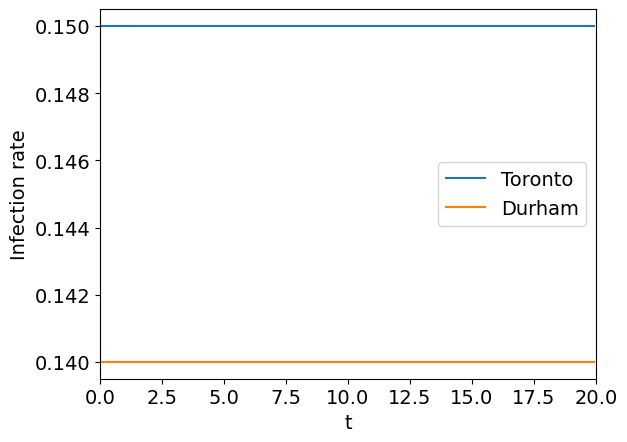

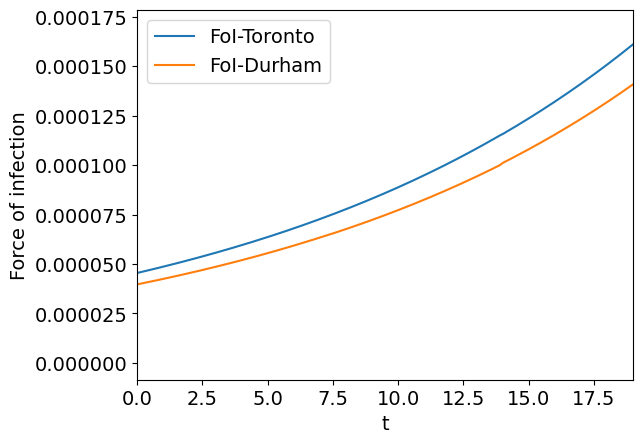

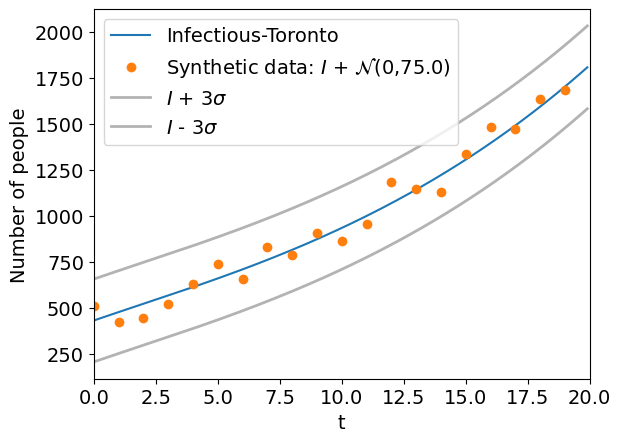

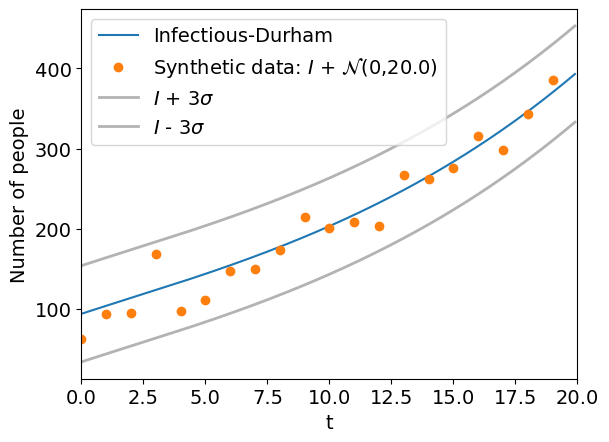

In [5]:

path = '/Users/sudhipv/documents/plos_coupledode/codes/figs/'


filepath =  os.path.join(path,'infrate_initial.pdf')
plt.figure(1)
plt.plot(tmoh, beta_i[:,0], label='Toronto')
plt.plot(tmoh, beta_i[:,1], label='Durham')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Infection rate') 
# plt.grid()
# plt.show()
# plt.savefig(filepath)


filepath =  os.path.join(path,'FoI.pdf')
plt.figure(2)
plt.plot(tmoh, L_Force[:,0], label='FoI-Toronto')
plt.plot(tmoh, L_Force[:,1], label='FoI-Durham')
plt.legend(loc='best')
plt.xlim([0,tlim-1])
plt.xlabel('t')
plt.ylabel('Force of infection')
# plt.grid()
# plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'toronto_full_2phu.pdf')

# err = np.dot((Data[tstart:tlim,0] - I_model - mu), (Data[tstart:tlim,0] - I_model - mu))
# print(err)
plt.figure(4)
plt.plot(tmoh, I[:,0], label='Infectious-Toronto')
plt.plot(t, I_synthetic[:,0], 'o',label='Synthetic data: $I$ + $\mathcal{N}$(0,'+ f'{sigma[0]}'+')')

plt.plot(tmoh, I[:,0] + 3*sigma[0], '-',linewidth=2, label='$I$ + $3\sigma$', color='0.7')

plt.plot(tmoh, I[:,0] - 3*sigma[0], '-',linewidth=2, label='$I$ - $3\sigma$', color='0.7')

plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
# plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'durham_full_2phu.pdf')

plt.figure(5)
# plt.plot(t, S[:,1], label='Susceptible-2')
# plt.plot(t, E[:,1],  label='Exposed-2')
plt.plot(tmoh, I[:,1],  label='Infectious-Durham')
plt.plot(t, I_synthetic[:,1], 'o',label='Synthetic data: $I$ + $\mathcal{N}$(0,' + f'{sigma[1]}' + ')')


plt.plot(tmoh, I[:,1]+ 3*sigma[1], '-',linewidth=2, label='$I$ + $3\sigma$', color='0.7')

plt.plot(tmoh, I[:,1]-3*sigma[1], '-',linewidth=2, label='$I$ - $3\sigma$', color='0.7')

# plt.plot(t, R[:,1], label='Recoverd-2')
# plt.plot(t, D[:,1], label='Dead-2')
# plt.plot(t, N[:,1],  label='N-2')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
# plt.savefig(filepath)
plt.show()

### Computing the log likelihood for coupled PHUs 

In [6]:

param1 = np.linspace(0.0,0.2,200)  # a0
param2 = np.linspace(0.0,0.2,200) # a1


L = np.zeros([len(param1),len(param2)])

Lhsum = np.zeros([len(param1),len(param2)])


for p1 in range(len(param1)):
    
    for p2 in range(len(param2)):

        Lprod = 1
        Lsum = 0

    
        beta_i[:,0] = param1[p1] 
    
        beta_i[:,1] = param2[p2] 
    
        beta_e[:,0] = beta_i[:,0]
        beta_e[:,1] = beta_i[:,1]

#### With mobility tensor   

        for kk in range(1,len(tmoh)):

            for gg in range(0,N_city):

                L_sum = 0
                for ll in range(0,N_city):

                    Nlm = 0
                    L_cityinf = 0
                    
                    for mm in range(0,N_city):
                        Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                        # original
                        # L_cityinf = L_cityinf + (beta_e[kk-1,mm] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,mm] * M[2,mm,ll,kk-1] * I[kk-1,mm])

                        
                        # beta changed
                        L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                    L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


                L_Force[kk-1,gg] = L_sum


                S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
                E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
                I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
                R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
                D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
                N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


                ## For collecting the model output only at data points

                if( kk%ndiv == 0):
                    
                    idxmoh = int(kk/ndiv)
                    # idxmoh = idxmoh + 1
                    # I_model[idxmoh] = I[kk,0]


                    # if(p1 == 2): 
                    #     print("kk is", kk)
                    #     print("idxmoh is",idxmoh)

                    
                ### Likelihood computation

                    multiplier = (1/(np.sqrt(2*np.pi)*sigma[gg]))


                    err = (I_synthetic[idxmoh,gg] - I[kk,gg] - mu[gg])**2
                            
                    # if(p1 == 72):
                    #     print("error is ", err)

                    Lprod = Lprod * multiplier * np.exp(-1 * (err/(2*sigma[gg]**2)))
                # log likelihood
                    Lsum = Lsum  + np.log(multiplier) - (err/(2*sigma[gg]**2)) 

                    # if(p1 == 50):
                    #     print("Lsum is", Lsum)
                    #     print("error /2sigma is", (err/(2*sigma[gg]**2)))
                    #     print("Lprod is", Lprod)
                



        L[p1,p2] = Lsum

        Lhsum[p1,p2] = Lprod


In [19]:


ind = np.unravel_index(np.argmax(L, axis=None), L.shape)

print(ind[0])
print(ind[1])

param_mle = np.zeros((2))

param_mle[0] = param1[ind[0]]

param_mle[1] = param2[ind[1]]

print(param_mle[0])
print(param_mle[1])
 
print("max values is", L[ind[0],ind[1]])



fig = plt.figure(2, figsize=(7,5))
ax = fig.gca()
X, Y = np.meshgrid(param1,param2)
print(np.shape(X))
print(np.shape(Y))
print(np.shape(L))
# plt.contourf(X,Y,np.transpose(L),levels=[-1500,-1000,-100])
Lt = np.transpose(L)
plt.pcolormesh(X,Y,Lt,vmin=-500)
plt.xlabel('$a_{0}^{1}$')
plt.ylabel('$a_{0}^{2}$')


# filepath =  os.path.join(path,'LL_full_a01_a02.pdf')


# plt.axvline(x=a0, color='black', label=f'Truth = {a0}')

# plt.axhline(y=a1, color='black', label=f'Truth = {a1}')

ax.scatter(a01,a02,color='black', label=f'Truth = {a01, a02}')
ax.scatter(param1[ind[0]],param2[ind[1]],color='red', label=f'MLE = ({param1[ind[0]]:.3f}, {param2[ind[1]]:.3f})')

plt.colorbar()
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('/Users/sudhipv/documents/sequential_calibration/mle/coupledPHU/LL_full_a01_a02.pdf',bbox_inches='tight')
plt.show()




ind2 = np.unravel_index(np.argmax(Lhsum, axis=None), Lhsum.shape)

print(ind2[0])
print(ind2[1])
print(param1[ind2[0]])
print(param2[ind2[1]])

print("max values is", Lhsum[ind2[0],ind2[1]])


# filepath =  os.path.join(path,'Likelihood_synthetic_a01_a11.pdf')

# fig = plt.figure(3)
# ax = fig.gca()
# LhsumT = np.transpose(Lhsum)
# plt.pcolormesh(X,Y,LhsumT,vmin=-100)
# plt.xlabel('$a_{01}$')
# plt.ylabel('$a_{11}$')

# ax.scatter(param1[ind2[0]],param2[ind2[1]],color='red', label='Point')

# plt.savefig(filepath)
# plt.show()


%matplotlib
from mpl_toolkits import mplot3d

fig = plt.figure(4,figsize=(7,5))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Lt, 100, cmap='binary')

ax.contour3D(X, Y, Lt, 100, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$a_{0}^{1}$', labelpad=10)
ax.set_ylabel('$a_{0}^{2}$', labelpad=10)
ax.set_zlabel('log likelihood', labelpad=15)
plt.tight_layout()
plt.savefig('/Users/sudhipv/documents/sequential_calibration/mle/coupledPHU/3dloglikelihood.pdf', bbox_inches='tight')
fig.show()

# np.savetxt('./Lt.dat',Lt)

150
138
0.15075376884422112
0.13869346733668342
max values is -189.9621008264592
(200, 200)
(200, 200)
(200, 200)
150
138
0.15075376884422112
0.13869346733668342
max values is 3.1659776183200284e-83
Using matplotlib backend: MacOSX


/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_90957/4122499076.py:83: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'edgecolor'
  ax.contour3D(X, Y, Lt, 100, rstride=1, cstride=1,


#### Using MLE values to predict infections

In [24]:


beta_i[:,0] = param_mle[0]
    
beta_i[:,1] = param_mle[1]
    
beta_e[:,0] = beta_i[:,0]
beta_e[:,1] = beta_i[:,1]



idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                L_cityinf = L_cityinf + (beta_e[kk-1,mm] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,mm] * M[2,mm,ll,kk-1] * I[kk-1,mm])


            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        

path = '/Users/sudhipv/documents/coupledode/codes/Inference/MLE/coupledPHU/synthetic/figs/'


filepath =  os.path.join(path,'infrate_MLE.pdf') 
plt.figure(1)
plt.plot(tmoh, beta_i[:,0], label='Toronto')
plt.plot(tmoh, beta_i[:,1], label='Durham')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Infection rate') 
# plt.grid()
plt.show()
# plt.savefig(filepath)


filepath =  os.path.join(path,'FoI_MLE.pdf') 
plt.figure(2)
plt.plot(tmoh, L_Force[:,0], label='FoI-Toronto')
plt.plot(tmoh, L_Force[:,1], label='FoI-Durham')
plt.legend(loc='best')
plt.xlim([0,tlim-1])
plt.xlabel('t')
plt.ylabel('Force of infection')
# plt.grid()
# plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'toronto_prediction_full_two.pdf')

# err = np.dot((Data[tstart:tlim,0] - I_model - mu), (Data[tstart:tlim,0] - I_model - mu))
# print(err)
plt.figure(4)
plt.plot(tmoh, I[:,0], label='Toronto prediction')
plt.plot(t, I_model[:,0], 'o',label='Original model output')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
# plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'durham_prediction_full_two.pdf')

plt.figure(5)
# plt.plot(t, S[:,1], label='Susceptible-2')
# plt.plot(t, E[:,1],  label='Exposed-2')
plt.plot(tmoh, I[:,1],  label='Durham prediction')
plt.plot(t, I_model[:,1], 'o',label='Original model output')
# plt.plot(t, R[:,1], label='Recoverd-2')
# plt.plot(t, D[:,1], label='Dead-2')
# plt.plot(t, N[:,1],  label='N-2')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
# plt.savefig(filepath)
plt.show()


: 